In [1]:
from scipy.io import loadmat
import os
import numpy as np
import pandas as pd
from imblearn.ensemble import RUSBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import pickle
import matplotlib.pyplot as plt

In [2]:
Data_path = 'D:\Classifier\Calssification2022_JZ\Code&Dataset\Week13_Classification_Final\Preprocessing'
Data_name = os.listdir(Data_path)
Data_name = [p for p in Data_name if 'mat' in p.split('.')]
Data_name = [p for p in Data_name if ('Site1' not in p.split('_'))&('Site2' not in p.split('_'))]

## 0: veh, 1:ped, 2:bike, 3:wheelchair 

In [42]:
Indicators = {
    'VehData':0,
    'PedData':1,
    'BikeData':2,
    'WheelchairData':3
}
column_names = ['TrajID','Mean_dis','Point_count','Dir','Height','Var_height','Len','Area','Label']
Train_Data = []
for i in range(len(Data_name)):
    data = loadmat(os.path.join(Data_path,Data_name[i]))
    class_name = list(data.keys())[3]
    data = data[class_name]
    class_ind = Indicators[class_name]
    class_col = (np.ones(len(data))*class_ind).reshape(-1,1).astype('int')
    try:
        data = np.concatenate([data[:,-3].reshape(-1,1).astype(int),data[:,:7],class_col],axis = 1)
        data = pd.DataFrame(data,columns=column_names)
    except:
        continue
    Train_Data.append(data)

In [52]:
Valid_train_data = []
for Trajs in Train_Data:
    for ind,traj in Trajs.groupby('TrajID'):
        if ind == -1:
            continue
        if len(traj) > 20:
            traj.Len = traj.Len.max()
            Valid_train_data.append(traj)

In [53]:
Valid_train_data = pd.concat(Valid_train_data)

In [54]:
X,y = np.array(Valid_train_data.iloc[:,1:-1]),np.array(Valid_train_data.iloc[:,-1])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [56]:
rusboost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=0)
rusboost.fit(X_train, y_train) 

RUSBoostClassifier(n_estimators=200, random_state=0)

In [57]:
y_pred = rusboost.predict(X_test)

# Train Model and save

In [22]:
path = 'D:\Classifier\Calssification2022_JZ\Code&Dataset\ThreeCasesinPaper\Case 1_TrajectoryGreaterThan10Frames\ClassificationConsideringHistoricalTrajectory\RUSBoost'

In [77]:
X_train = loadmat(os.path.join(path,'Train_Data.mat'))['Train_Data']
y_train = loadmat(os.path.join(path,'Train_Target.mat'))['Train_Target']
y_train = y_train.flatten()
X_test = loadmat(os.path.join(path,'Test_Data.mat'))['Test_Data']
y_test = loadmat(os.path.join(path,'Test_Target.mat'))['Test_Target']
y_test = y_test.flatten()
ind = [i for i in range(7) if (i !=0) & (i!= 4)&(i!=2)]
X_train = X_train[:,ind] 
X_test = X_test[:,ind] 

In [78]:
tree = DecisionTreeClassifier(max_depth=30)

In [79]:
rusboost = RUSBoostClassifier(base_estimator = tree, n_estimators=300,learning_rate=0.1
                          , random_state=0)
rusboost.fit(X_train, y_train) 

RUSBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=30),
                   learning_rate=0.1, n_estimators=300, random_state=0)

In [80]:
y_pred = rusboost.predict(X_test)

In [103]:
X_train[y_train == 2]

array([[13.        ,  1.06636   ,  0.92677674,  0.06198249],
       [10.        ,  1.07324   ,  1.23605874,  0.076071  ],
       [10.        ,  0.93357   ,  1.04778488,  0.06529413],
       ...,
       [17.        ,  1.1832    ,  0.88411459,  0.293055  ],
       [ 6.        ,  1.32032   ,  0.66174693,  0.12049226],
       [47.        ,  1.78356   ,  1.23605874,  0.51623365]])

In [101]:
test = np.array([[46.        ],
       [ 1.20906826],
       [ 0.61952704],
       [ 0.26258078]]).reshape(1,-1)

In [102]:
rusboost.predict(test)

array([2], dtype=uint8)

In [81]:
confusion_matrix(y_test, y_pred)

array([[2904,    0,    0,    0],
       [   0, 2660,    0,    2],
       [   1,   19,  354,   16],
       [   0,   12,    1,  703]], dtype=int64)

In [82]:
balanced_accuracy_score(y_test, y_pred)  

0.9721961420776001

In [83]:
filename = 'D:\Lidar-Tracker\Classifier\Classifier.sav'
pickle.dump(rusboost, open(filename, 'wb'))

In [102]:
model = pickle.load(open(filename, 'rb'))

In [103]:
y_pred = model.predict(X_test)

In [104]:
confusion_matrix(y_test, y_pred)

array([[2904,    0,    0,    0],
       [   0, 2659,    0,    3],
       [   1,  157,  188,   44],
       [   0,  111,   68,  537]], dtype=int64)

In [90]:
data = pd.read_csv(r'D:\LiDAR_Data\MidTown\California\OutputFile\OutputTrajs/Trajctories_0.csv')

In [91]:
data_test = data.loc[:,['ObjectID','Distance_Mea','Point_Cnt','Dir_X_Bbox','Height','Length','Area']]
data_temp = []
for i,df in data_test.groupby('ObjectID'):
    df.Length = df.Length.max()
    data_temp.append(df)
data_temp = pd.concat(data_temp)
data_temp = data_temp.fillna(method = 'pad')

In [92]:
X_test = np.array(data_temp.iloc[:,1:])

In [93]:
y_pred = model.predict(X_test)

NameError: name 'model' is not defined

In [87]:
Traj = pd.read_csv('D:/LiDAR_Data/MidTown/California/OutputFile/OutputTrajs/Trajctories_1.csv')
Trajs = []
for i,g in Traj.groupby('ObjectID'):
    Trajs.append(g)

In [120]:
Traj = pd.read_csv('D:/LiDAR_Data/MidTown/California/OutputFile/OutputTrajs/Trajctories_0.csv')

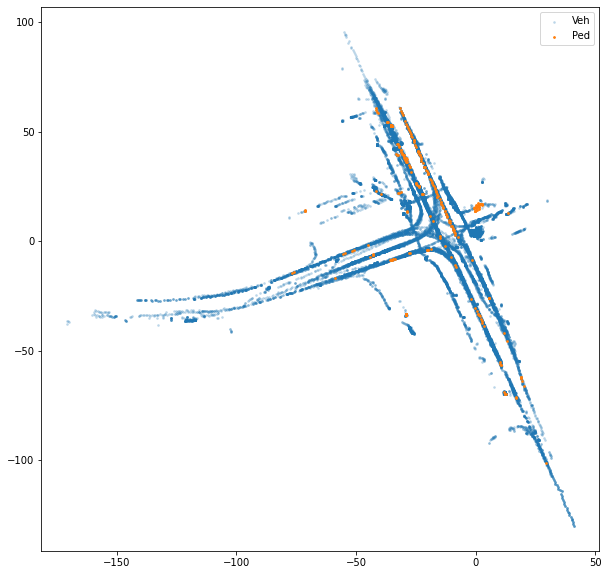

In [121]:
plt.figure(figsize=(10,10))
plt.scatter(Traj.loc[Traj.Class == 1,'Coord_X_Mea'],Traj.loc[Traj.Class == 1,'Coord_Y_Mea'], s = 3, alpha = 0.2,label = 'Veh')
plt.scatter(Traj.loc[Traj.Class == 2,'Coord_X_Mea'],Traj.loc[Traj.Class == 2,'Coord_Y_Mea'], s = 3,label = 'Ped')
# plt.scatter(Traj.loc[Traj.Class == 3,'Coord_X_Mea'],Traj.loc[Traj.Class == 3,'Coord_Y_Mea'], s = 3,label = 'Cyc')
# plt.scatter(Traj.loc[Traj.Class == 4,'Coord_X_Mea'],Traj.loc[Traj.Class == 4,'Coord_Y_Mea'], s = 3,label = 'Wheel')
plt.legend(fontsize = 10)
plt.show()

In [122]:
from sklearn.neighbors import NearestNeighbors

In [135]:
Coord_cur = np.array(Traj.loc[Traj.FrameIndex == 2,['Coord_X_Mea','Coord_Y_Mea']])
Coord_next = np.array(Traj.loc[Traj.FrameIndex == 3,['Coord_X_Mea','Coord_Y_Mea']])

In [166]:
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(Coord_next)

In [167]:
distances, indices = nbrs.kneighbors(Coord_cur)

In [170]:
indices

array([[11],
       [ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14]], dtype=int64)

In [159]:
distances[0]

array([0.48491328])

In [162]:
Coord_cur[0]

array([-55.078278, -11.707249])

In [163]:
Coord_next[1]

array([-78.630936, -15.284306])

In [5]:
Labels = []
for t in Trajs:
    uni,cnt = np.unique(np.array(t.Class),return_counts = True)
    Labels.append(uni[np.argmax(cnt)])

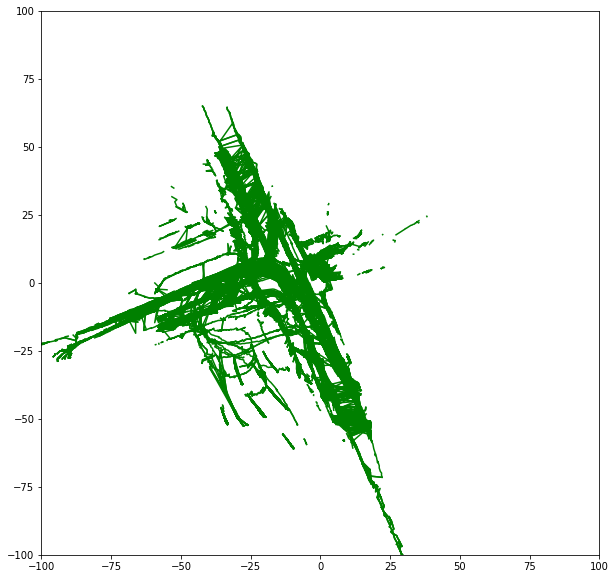

In [6]:
plt.figure(figsize=(10,10))
plt.xlim(-100,100)
plt.ylim(-100,100)
for i,t in enumerate(Trajs):
    if Labels[i] == 1:
        plt.plot(t.Coord_X_Mea,t.Coord_Y_Mea,c = 'g')
    elif Labels[i] == 2:
        plt.plot(t.Coord_X_Mea,t.Coord_Y_Mea,c = 'r')
    elif Labels[i] == 3:
        plt.plot(t.Coord_X_Mea,t.Coord_Y_Mea,c = 'y')
    else:
        plt.plot(t.Coord_X_Mea,t.Coord_Y_Mea,c = 'b')
plt.show()

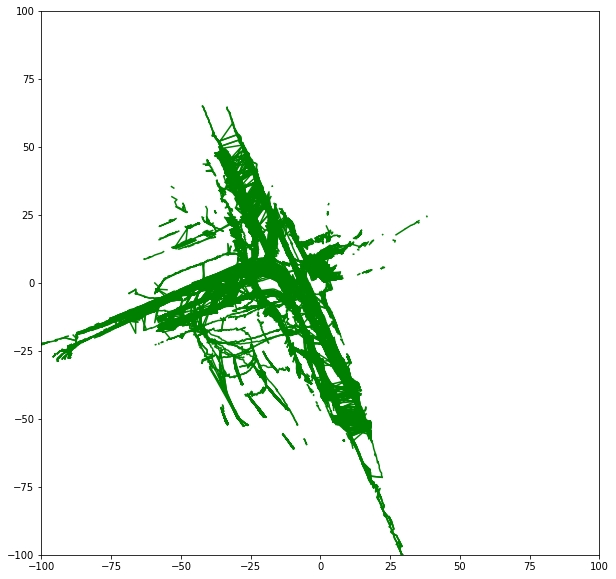

In [7]:
plt.figure(figsize=(10,10))
plt.xlim(-100,100)
plt.ylim(-100,100)
for i,t in enumerate(Trajs):
    if Labels[i] == 1:
        plt.plot(t.Coord_X_Mea,t.Coord_Y_Mea,c = 'g')
plt.show()

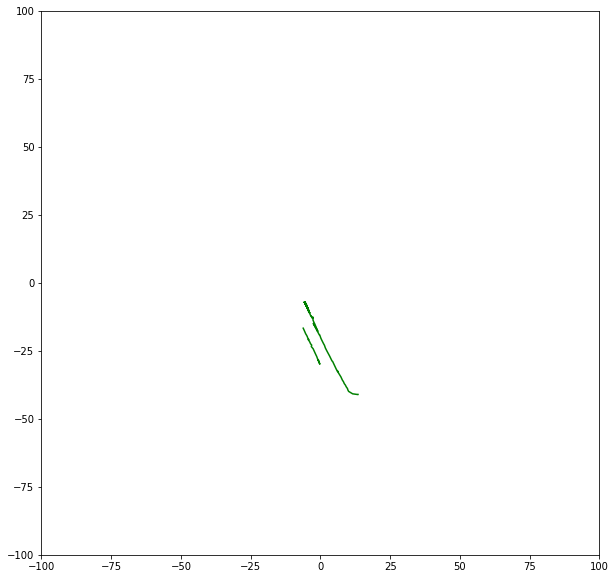

In [8]:
plt.figure(figsize=(10,10))
plt.xlim(-100,100)
plt.ylim(-100,100)
for i,t in enumerate(Trajs):
    if Labels[i] == 2:
        plt.plot(t.Coord_X_Mea,t.Coord_Y_Mea,c = 'g')
plt.show()

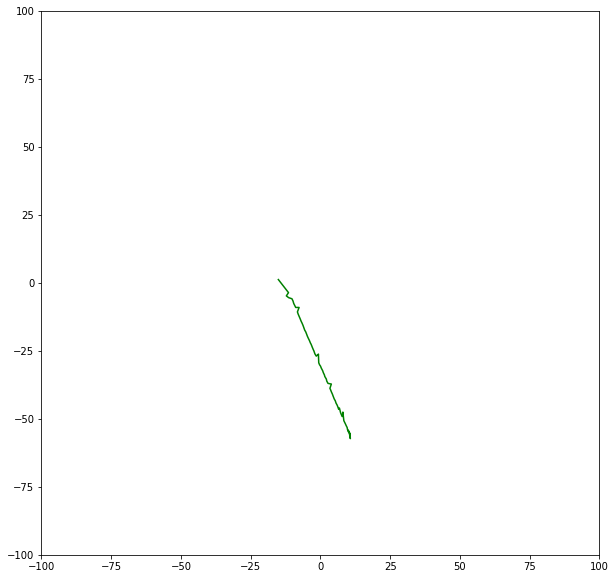

In [9]:
plt.figure(figsize=(10,10))
plt.xlim(-100,100)
plt.ylim(-100,100)
for i,t in enumerate(Trajs):
    if Labels[i] == 3:
        plt.plot(t.Coord_X_Mea,t.Coord_Y_Mea,c = 'g')
plt.show()

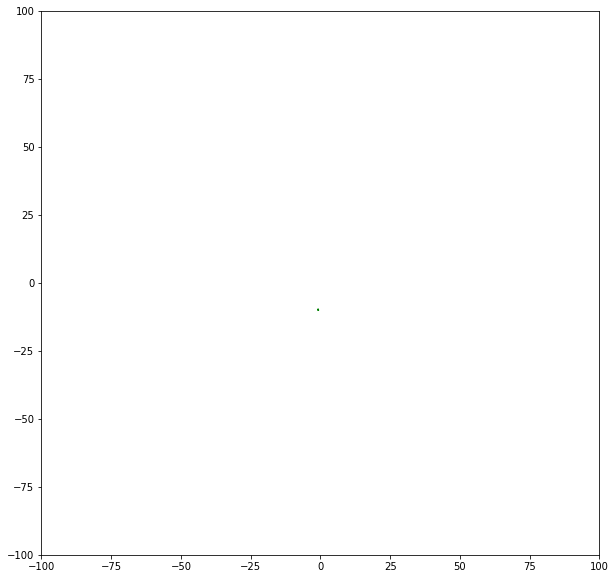

In [10]:
plt.figure(figsize=(10,10))
plt.xlim(-100,100)
plt.ylim(-100,100)
for i,t in enumerate(Trajs):
    if Labels[i] == 4:
        plt.plot(t.Coord_X_Mea,t.Coord_Y_Mea,c = 'g')
plt.show()